# Argo trajectories

Argovis indexes and serves a collection of estimated Argo parking-depth trajectories and velocities, originally from [https://journals.ametsoc.org/view/journals/atot/aop/JTECH-D-22-0065.1/JTECH-D-22-0065.1.xml](https://journals.ametsoc.org/view/journals/atot/aop/JTECH-D-22-0065.1/JTECH-D-22-0065.1.xml). In this notebook, we'll tour some basics of the dataset and API.

## Setup

In addition to importing a few python packages, make sure to plug in your Argovis API key for `API_KEY` in the next cell. If you don't have a free Argovis API key yet, get one at https://argovis-keygen.colorado.edu/.

In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import requests, xarray, pandas, math, datetime, copy
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from datetime import datetime, timedelta
from argovisHelpers import helpers as avh

def simple_map(longitudes, latitudes, z=None, zlabel=None, polygon=None, title='', fig=None, figIndex=None, marker=None, secondaries=None):
    fnt_sz = 20
    if fig:
        ax = fig.add_subplot(figIndex[0], figIndex[1], figIndex[2], projection=ccrs.LambertConformal(cutoff=-60))
    else:
        fig = plt.figure(figsize=(20,10))
        ax = fig.add_subplot(1, 1, 1, projection=ccrs.LambertConformal(cutoff=-60))
    gl = ax.gridlines(draw_labels=True,color='black')
    if z:
        s = ax.scatter(longitudes, latitudes, c=z, transform=ccrs.PlateCarree(), s=130)
        cb = plt.colorbar(s, pad=0.1)
        cb.set_label(zlabel, rotation=270, labelpad=20)
    else:
        s = ax.scatter(longitudes, latitudes,transform=ccrs.PlateCarree(), s=130)
    
    if polygon:
        plt.plot([x[0] for x in polygon],[x[1] for x in polygon],'-k', linewidth=5, color='red',transform=ccrs.PlateCarree()) 
    if marker:
        plt.plot(marker[0],marker[1],'Xr', transform=ccrs.PlateCarree(), markersize=20)
    if secondaries:
        for sec in secondaries:
            ax.scatter(sec['lon'], sec['lat'],transform=ccrs.PlateCarree(), color=sec['color'], marker='x', s=150, linewidth=3)
    plt.rcParams['font.size'] = fnt_sz
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(cfeature.LAND)
    plt.title(title, fontdict={'fontsize':fnt_sz})
    
API_KEY=''
API_PREFIX = 'https://argovis-api.colorado.edu/'

## Search and plot a tropical cyclone

Let's start by looking at Argo trajectory speeds and zonal and meridional velocities off the American East Coast in December 2020. The Argo trajectories API follows the same patterns for temporospatial and data filtering queries as other Argovis datasets:

In [2]:
polygon = [[-82,20],[-62,20],[-72,30],[-62,40],[-82,40],[-82,20]]
traj_param = {
    'startDate': '2020-12-01T00:00:00Z',
    'endDate': '2021-01-01T00:00:00Z',
    'polygon': polygon,
    'data': 'velocity_zonal,velocity_meridional,speed'
}

traj = avh.query('argotrajectories', options=traj_param, apikey=API_KEY, apiroot=API_PREFIX)

https://argovis-api.colorado.edu/argotrajectories?startDate=2020-12-01T00%3A00%3A00.000000Z&endDate=2020-12-31T00%3A00%3A00.000000Z&polygon=%5B%5B-82%2C+20%5D%2C+%5B-62%2C+20%5D%2C+%5B-72%2C+30%5D%2C+%5B-62%2C+40%5D%2C+%5B-82%2C+40%5D%2C+%5B-82%2C+20%5D%5D&data=velocity_zonal%2Cvelocity_meridional%2Cspeed
https://argovis-api.colorado.edu/argotrajectories?startDate=2020-12-31T00%3A00%3A00.000000Z&endDate=2021-01-01T00%3A00%3A00.000000Z&polygon=%5B%5B-82%2C+20%5D%2C+%5B-62%2C+20%5D%2C+%5B-72%2C+30%5D%2C+%5B-62%2C+40%5D%2C+%5B-82%2C+40%5D%2C+%5B-82%2C+20%5D%5D&data=velocity_zonal%2Cvelocity_meridional%2Cspeed


/tmp/ipykernel_41/3527685117.py:26: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-k" (-> color='k'). The keyword argument will take precedence.
  plt.plot([x[0] for x in polygon],[x[1] for x in polygon],'-k', linewidth=5, color='red',transform=ccrs.PlateCarree())
/usr/local/envs/argovis_demos/lib/python3.9/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/50m/physical/ne_50m_land.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)
/usr/local/envs/argovis_demos/lib/python3.9/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/50m/physical/ne_50m_coastline.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)
/usr/local/envs/argovis_demos/lib/python3.9/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/50m/cultural/ne_50m_admin_0_boundary_lines_lan

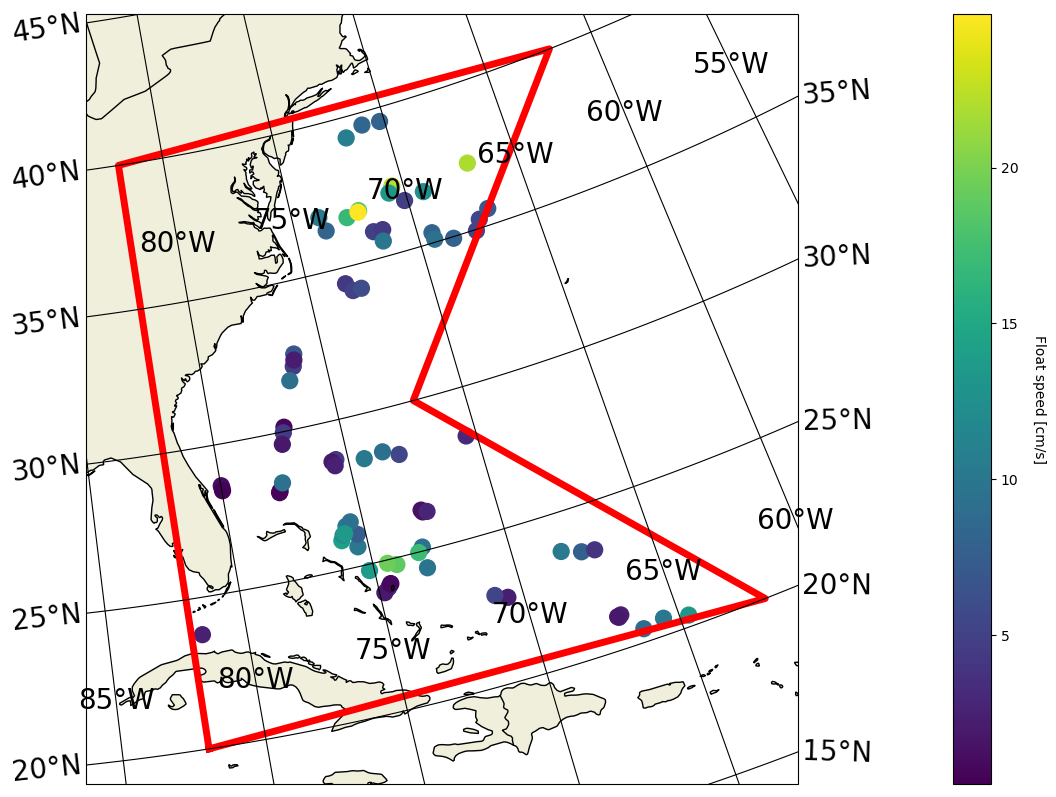

In [3]:
traj_lon = [x['geolocation']['coordinates'][0] for x in traj]
traj_lat = [x['geolocation']['coordinates'][1] for x in traj]
traj_speed = [x['data'][x['data_info'][0].index('speed')][0] for x in traj]
simple_map(traj_lon, traj_lat, z=traj_speed, polygon=polygon, zlabel='Float speed [cm/s]')

/tmp/ipykernel_41/3527685117.py:26: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-k" (-> color='k'). The keyword argument will take precedence.
  plt.plot([x[0] for x in polygon],[x[1] for x in polygon],'-k', linewidth=5, color='red',transform=ccrs.PlateCarree())


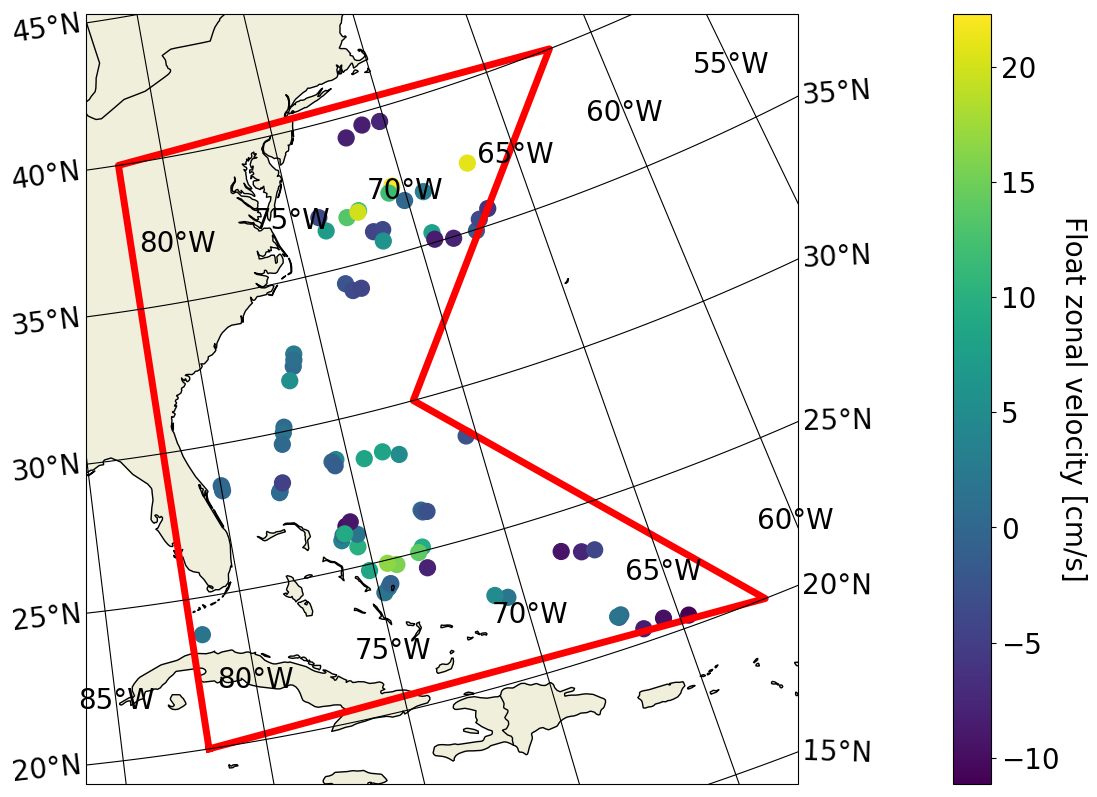

In [4]:
traj_zonal = [x['data'][x['data_info'][0].index('velocity_zonal')][0] for x in traj]
simple_map(traj_lon, traj_lat, z=traj_zonal, polygon=polygon, zlabel='Float zonal velocity [cm/s]')

/tmp/ipykernel_41/3527685117.py:26: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-k" (-> color='k'). The keyword argument will take precedence.
  plt.plot([x[0] for x in polygon],[x[1] for x in polygon],'-k', linewidth=5, color='red',transform=ccrs.PlateCarree())


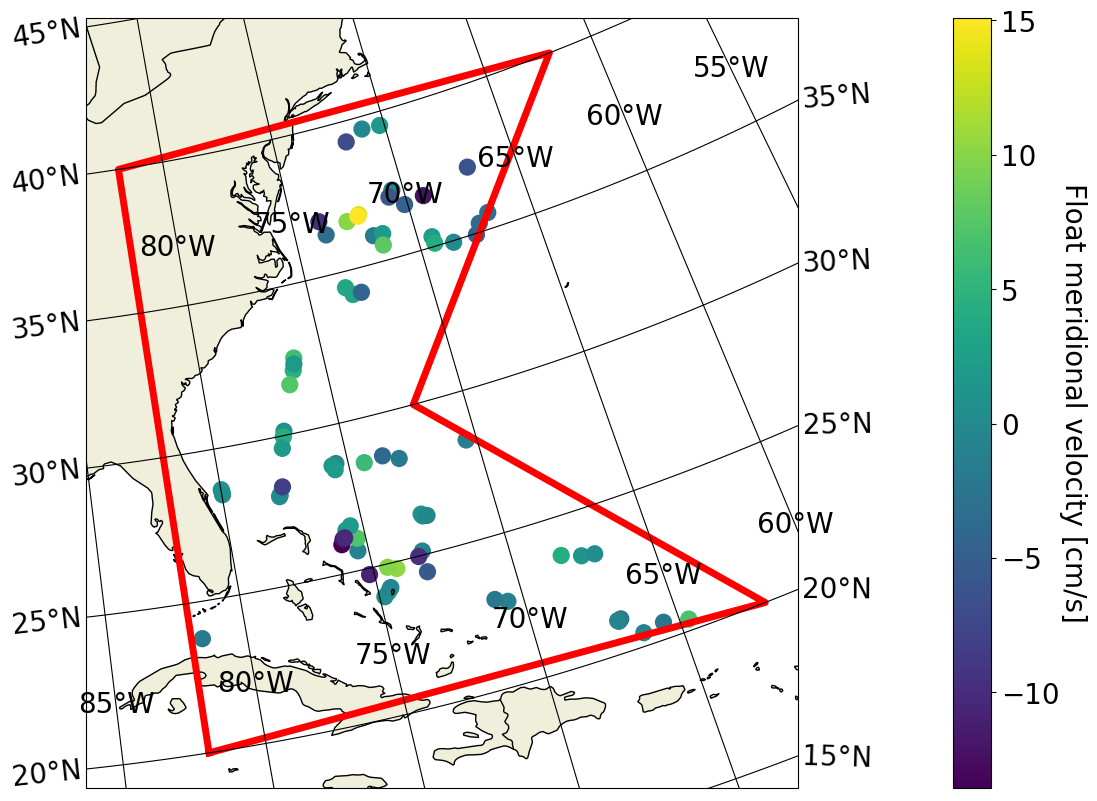

In [5]:
traj_meridional = [x['data'][x['data_info'][0].index('velocity_meridional')][0] for x in traj]
simple_map(traj_lon, traj_lat, z=traj_meridional, polygon=polygon, zlabel='Float meridional velocity [cm/s]')